# Описание задачи

Описание услуг
Оператор предоставляет два основных типа услуг:

    -Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
    -Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:

    - Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
    - Выделенная линия технической поддержки (Tech Support);
    - Облачное хранилище файлов для резервного копирования данных (Online Backup);
    - Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Чтение данных
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом.
Она состоит из нескольких таблиц:

    - contract — информация о договорах;
    - personal — персональные данные клиентов;
    - internet — информация об интернет-услугах;
    - phone — информация об услугах телефонии.  
Таблица contract

    - customerID — ID абонента;
    - BeginDate — дата начала действия договора;
    - EndDate — дата окончания действия договора;
    - Type — тип оплаты: раз в год-два или ежемесячно;
    - PaperlessBilling — электронный расчётный лист;
    - PaymentMethod — тип платежа;
    - MonthlyCharges — расходы за месяц;
    - TotalCharges — общие расходы абонента.
Таблица personal:

    - customerID — ID пользователя;
    - gender — пол;
    - SeniorCitizen — является ли абонент пенсионером;
    - Partner — есть ли у абонента супруг или супруга;
    - Dependents — есть ли у абонента дети.
Таблица internet

    - customerID — ID пользователя;
    - InternetService — тип подключения;
    - OnlineSecurity — блокировка опасных сайтов;
    - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    - DeviceProtection — антивирус;
    - TechSupport — выделенная линия технической поддержки;
    - StreamingTV — стриминговое телевидение;
    - StreamingMovies — каталог фильмов.
Таблица phone

    - customerID — ID пользователя;
    -MultipleLines — подключение телефона к нескольким линиям одновременно.    
Информация о договорах актуальна на 1 февраля 2020.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#import re
import matplotlib.pyplot as plt
#import datetime
from datetime import datetime as dt
from dateutil import relativedelta
import os
import sys

import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.model_selection import (train_test_split,GridSearchCV,cross_val_score)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer,SimpleImputer
from sklearn.metrics import (confusion_matrix,precision_recall_curve,roc_auc_score,classification_report,
                             accuracy_score,make_scorer,roc_curve,RocCurveDisplay,
                             recall_score,precision_score,ConfusionMatrixDisplay)
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder, MaxAbsScaler) 


from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.metrics import BinaryAccuracy, AUC

import psycopg2
from sqlalchemy import create_engine,inspect,Table, Column, Integer, String, MetaData
#sql.compiler.IdentifierPreparer.quote_identifier
RANDOM_STATE = 120525
TEST_SIZE = 0.25

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
pd.options.display.float_format = '{:,.4f}'.format
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Using device: cuda


sklearn.exceptions.ConvergenceWarning('ignore')

In [2]:
# функиция преобразования в bool 
def bul(dat,col,tru,nt):
    dat[col][dat[col]==tru]=1 
    dat[col][dat[col]==nt]=0
    #dat[col]=dat[col].astype('boolean')
    voc_k[col]=(nt,tru)

In [3]:
def unbul(dat,col,tru,nt):
    dat[col][dat[col]==True]=tru 
    dat[col][dat[col]==False]=nt
    dat[col]=dat[col].astype('object')
    

In [4]:
def col_feature_tag (df,tag):
    
    for col in df.columns:
        print (col,'количество уникальных значений', (df[col].nunique(dropna=False)))
        plt.figure(figsize=(3, 2))
        if df[col].nunique() < 60:
            display(df[col].value_counts(dropna=False))
        if df[col].nunique() < 60:
            print (col)
            sns.countplot(y=col, data=df,hue =tag)
            plt.show()
    return()  

In [5]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 
#sqlalchemy.sql.compiler.IdentifierPreparer.quote_identifier(name) 

inspector = inspect(engine)
name_df = inspector.get_table_names()

print(inspector.get_table_names())

['contract', 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time', 'internet', 'personal', 'phone']


In [6]:
name_df = ['df_contract','df_internet', 'df_personal', 'df_phone']
name_tab = ['contract','internet', 'personal', 'phone']

In [7]:
for name_t,MyDf in zip(name_tab,name_df):
    globals()[MyDf] = pd.read_sql_table(name_t, engine)#,columns=lambda x: str(x))
engine.dispose()    

In [8]:
df_phone.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


# Иследовательский анализ и предобработка данных

## анализ базы contract

In [9]:
display(df_contract.head())
df_contract.info()
display('Дата заключения самого раннего договора ',df_contract['BeginDate'].min())
display('Дата заключения самого позднего договора ',df_contract['BeginDate'].max())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


'Дата заключения самого раннего договора '

'2013-10-01'

'Дата заключения самого позднего договора '

'2020-02-01'

In [12]:
# преобразование данных could not convert string to float: ' '
voc_k = pd.DataFrame()
df_contract['EndDate'][df_contract['EndDate']=='No'] = np.nan
df_contract['TotalCharges'][df_contract['TotalCharges']==' '] = 0
df_contract[['month_end','year_end','contract_day']] = np.nan

df_contract[['Type','PaymentMethod']] = df_contract[['Type','PaymentMethod']].astype('string')
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='ISO8601')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='ISO8601')

df_contract['taget'] =  ~pd.isnull(df_contract['EndDate'])

df_contract['year_begin'] = df_contract['BeginDate'].dt.year
df_contract['month_begin'] = df_contract['BeginDate'].dt.month

df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].apply(lambda x: float(x)) 
df_contract['TotalCharges'] = df_contract['TotalCharges'].apply(lambda x: float(x)) 
df_contract['month_end'][df_contract['taget']==True] = df_contract['EndDate'].dt.month
df_contract['year_end'][df_contract['taget']==True] = df_contract['EndDate'].dt.year
df_contract['contract_day'] [pd.notnull(df_contract['EndDate'])] = (df_contract['EndDate']-df_contract['BeginDate']).dt.days

bul(df_contract,'PaperlessBilling','Yes','No')

df_contract['month_paid'] = (df_contract['TotalCharges']/df_contract['MonthlyCharges']).astype('float')
df_contract['contract_use'] = (pd.to_datetime('2020-02-01')-df_contract['BeginDate']).dt.days
df_contract['contract_use'][df_contract['taget']==True] =(df_contract['EndDate']-df_contract['BeginDate']).dt.days 





df_contract = df_contract.copy()
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   string        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   string        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   month_end         1101 non-null   float64       
 9   year_end          1101 non-null   float64       
 10  contract_day      1101 non-null   float64       
 11  taget             7043 non-null   bool          
 12  year_begin        7043 non-null   int32         
 13  month_begin       7043 non-null   int32         
 14  month_paid        7043 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,month_end,year_end,contract_day,taget,year_begin,month_begin,month_paid,contract_use
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.8500,31.0400,NaN,NaN,NaN,False,2020,1,1.0399,31
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.9500,"2,071.8400",NaN,NaN,NaN,False,2017,4,36.3800,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,1,Mailed check,53.8500,226.1700,NaN,NaN,NaN,False,2019,10,4.2000,123
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.3000,"1,960.6000",NaN,NaN,NaN,False,2016,5,46.3499,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,1,Electronic check,70.7000,353.5000,NaN,NaN,NaN,False,2019,9,5.0000,153


In [13]:
display('количество дубликатов', df_contract.drop(['customerID'],axis=1).duplicated().sum())


'количество дубликатов'

np.int64(37)

## анализ базы internet

In [14]:
display(df_internet.head()) # 344.9+ KB

bul(df_internet,'OnlineSecurity','Yes','No')
bul(df_internet,'OnlineBackup','Yes','No')
bul(df_internet,'DeviceProtection','Yes','No')
bul(df_internet,'TechSupport','Yes','No')
bul(df_internet,'StreamingTV','Yes','No')
bul(df_internet,'DeviceProtection','Yes','No')
bul(df_internet,'StreamingMovies','Yes','No')
bul(df_internet,'InternetService','DSL','Fiber optic')
df_internet = df_internet.rename(columns={"InternetService": "ServiceDSL"})
df_internet_2 = df_internet.copy()
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   ServiceDSL        5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
dif_id_con_int = sorted(list(set(sorted(df_contract['customerID'].unique()))-set((sorted(df_internet['customerID'].unique())))))
#df_contract['customerID'].unique()- df_internet['customerID'].unique()
display('Количество отличающихся (отсутстувующих) в базе интернет клиентовэ',len(dif_id_con_int))
display('количество дубликатов', df_internet.drop(['customerID'],axis=1).duplicated().sum())

'Количество отличающихся (отсутстувующих) в базе интернет клиентовэ'

1526

'количество дубликатов'

np.int64(5389)

## анализ базы personal

In [16]:
display(df_personal.head())
df_personal = df_personal.rename(columns={"gender": "Male"})
bul(df_personal,'Male','Male','Female')
bul(df_personal,'SeniorCitizen','1','0')
bul(df_personal,'Partner','Yes','No')
bul(df_personal,'Dependents','Yes','No')
df_personal_2 = df_personal.copy()
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Male           7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [17]:
dif_id_con_per = sorted(list(set(sorted(df_contract['customerID'].unique()))-set((sorted(df_personal['customerID'].unique())))))
display('Количество отличающихся (отсутстувующих) в базе personal клиентов',len(dif_id_con_per))

dif_id_per_int = sorted(list(set(sorted(df_personal['customerID'].unique()))-set((sorted(df_internet['customerID'].unique())))))
#df_contract['customerID'].unique()- df_internet['customerID'].unique()
display('Количество отличающихся (отсутстувующих) в базе интернет клиентов',len(dif_id_per_int))
display('количество дубликатов', df_personal.drop(['customerID'],axis=1).duplicated().sum())

'Количество отличающихся (отсутстувующих) в базе personal клиентов'

0

'Количество отличающихся (отсутстувующих) в базе интернет клиентов'

1526

'количество дубликатов'

np.int64(7027)

## анализ базы phone

In [18]:
display(df_phone.head())
#df_phone.info()
df_phone = df_phone.rename(columns={"CustomerId": "customerID"})
bul(df_phone,'MultipleLines','Yes','No')
df_phone_2 = df_phone.copy()
df_phone.info()

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
dif_id_con_phone = sorted(list(set(sorted(df_contract['customerID'].unique()))-set((sorted(df_phone['customerID'].unique())))))
display(len(dif_id_con_phone))

dif_id_per_phone = sorted(list(set(sorted(df_personal['customerID'].unique()))-set((sorted(df_phone['customerID'].unique())))))
display(len(dif_id_per_phone))

dif_id_phone_int = sorted(list(set(sorted(df_phone['customerID'].unique()))-set((sorted(df_internet['customerID'].unique())))))
display(len(dif_id_phone_int))

display(dif_id_con_phone==dif_id_per_phone)

682

682

1526

True

## результаты предобработки 

    - преобразованы свойства (данные в столбцах), которые имели 2 униальных значения в тип boolean, другие свойства преобразованы в определенные типы из object 
    - введены новые свойства :
        - месяц начала контракта
        - месяц окончания контракта(при наличии)
        - год начала контракта
        - год окончания контракта(при наличии)
        - среднее количество месяцев month_paid оплаты contract_use (float)
        - дней контракта(contract_day) (если контракт открыт , то колучество дней до 01-02-2020)
        - target (1 , если контракт закрыт, 0 - нет)
        - Дата заключения самого раннего договора - '2013-10-01'
        - Дата заключения самого позднего договора - '2020-02-01'

# Объединение баз

In [20]:
df_all = pd.merge(df_contract,df_personal, how='left', on=['customerID'], validate='one_to_one').copy()
df_all = df_all.merge(df_internet, how='left', on='customerID').copy()
df_all = df_all.merge(df_phone, how='left', on='customerID').copy()


df_all['taget'] = df_all['taget'].astype('int32')
df_all = df_all.drop(['customerID'],axis=1).copy()
df_all = df_all.drop_duplicates().copy()
df_all.columns = [str(col) for col in df_all.columns]
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7039 non-null   string        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   string        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   month_end         1101 non-null   float64       
 8   year_end          1101 non-null   float64       
 9   contract_day      1101 non-null   float64       
 10  taget             7039 non-null   int32         
 11  year_begin        7039 non-null   int32         
 12  month_begin       7039 non-null   int32         
 13  month_paid        7039 non-null   float64       
 14  contract_use      7039 non-nu

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,month_end,year_end,contract_day,...,Partner,Dependents,ServiceDSL,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,NaT,Month-to-month,1,Electronic check,29.8500,31.0400,NaN,NaN,NaN,...,1,0,1,0,1,0,0,0,0,NaN
1,2017-04-01,NaT,One year,0,Mailed check,56.9500,"2,071.8400",NaN,NaN,NaN,...,0,0,1,1,0,1,0,0,0,0
2,2019-10-01,NaT,Month-to-month,1,Mailed check,53.8500,226.1700,NaN,NaN,NaN,...,0,0,1,1,1,0,0,0,0,0
3,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.3000,"1,960.6000",NaN,NaN,NaN,...,0,0,1,1,0,1,1,0,0,NaN
4,2019-09-01,NaT,Month-to-month,1,Electronic check,70.7000,353.5000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


# Анализ данных 

In [21]:
(df_all.columns)

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'month_end', 'year_end',
       'contract_day', 'taget', 'year_begin', 'month_begin', 'month_paid',
       'contract_use', 'Male', 'SeniorCitizen', 'Partner', 'Dependents',
       'ServiceDSL', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [22]:
col_features = ['Type', 'PaperlessBilling','PaymentMethod','taget',
       'month_end', 'year_end', 'year_begin', 'month_begin',
       'Male', 'SeniorCitizen', 'Partner', 'Dependents',
       'ServiceDSL', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

col_features1 = ['Type', 'PaperlessBilling','PaymentMethod','taget',       
       'Male', 'SeniorCitizen', 'Partner', 'Dependents']

In [23]:
nul_col = ['ServiceDSL', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines']

bul_col = ['PaperlessBilling','ServiceDSL', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection','taget','Male',
           'SeniorCitizen', 'Partner','Dependents', 
           'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines']

bul_col1 = ['PaperlessBilling','OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection','Male',
           'SeniorCitizen', 'Partner','Dependents', 
           'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines']

In [24]:
#df_all[nul_col] = df_all[nul_col].astype(str)
imp_mean = IterativeImputer(random_state=RANDOM_STATE)
#imputer = KNNImputer(n_neighbors=3,missing_values=np.nan)
#imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#imputer.fit_transform(df_all[nul_col])
#df_s = imp_mean.fit_transform(df_all[['ServiceDSL']])

for col_n in nul_col :
    #imputer.fit_transform(df_all[col_n])
    df_all[col_n] = imp_mean.fit_transform(df_all[[col_n]])
#df_all[nul_col]=df_all[nul_col].astype('boolean')    
df_all.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7039 non-null   string        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   string        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   month_end         1101 non-null   float64       
 8   year_end          1101 non-null   float64       
 9   contract_day      1101 non-null   float64       
 10  taget             7039 non-null   int32         
 11  year_begin        7039 non-null   int32         
 12  month_begin       7039 non-null   int32         
 13  month_paid        7039 non-null   float64       
 14  contract_use      7039 non-nu

## анализ категорийных даных с учетом taget 

BeginDate количество уникальных значений 77
EndDate количество уникальных значений 67
Type количество уникальных значений 3


Type
Month-to-month    3873
Two year          1693
One year          1473
Name: count, dtype: Int64

Type


<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

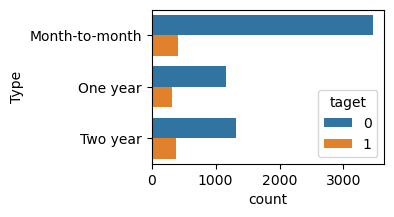

PaperlessBilling количество уникальных значений 2


PaperlessBilling
1    4170
0    2869
Name: count, dtype: int64

PaperlessBilling


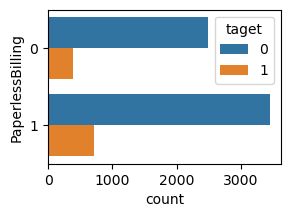

PaymentMethod количество уникальных значений 4


PaymentMethod
Electronic check             2365
Mailed check                 1609
Bank transfer (automatic)    1544
Credit card (automatic)      1521
Name: count, dtype: Int64

PaymentMethod


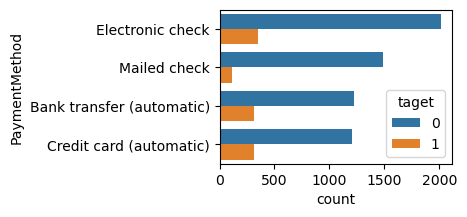

MonthlyCharges количество уникальных значений 1585
TotalCharges количество уникальных значений 6658
month_end количество уникальных значений 13


month_end
NaN        5938
11.0000     113
12.0000     107
9.0000      105
1.0000      103
10.0000      99
7.0000       97
6.0000       87
3.0000       86
8.0000       82
5.0000       81
4.0000       71
2.0000       70
Name: count, dtype: int64

month_end


<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

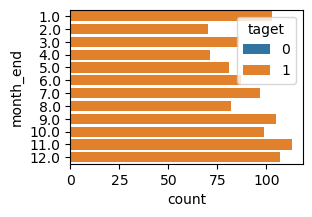

year_end количество уникальных значений 8


year_end
NaN           5938
2,019.0000     333
2,018.0000     285
2,017.0000     235
2,016.0000     140
2,015.0000      62
2,020.0000      39
2,014.0000       7
Name: count, dtype: int64

year_end


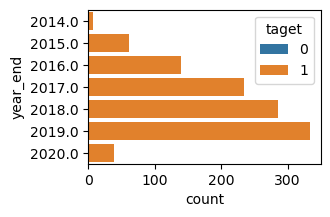

contract_day количество уникальных значений 232
taget количество уникальных значений 2


taget
0    5938
1    1101
Name: count, dtype: int64

taget


<Figure size 300x200 with 0 Axes>

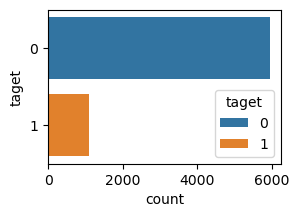

year_begin количество уникальных значений 8


year_begin
2019    1957
2014    1342
2018    1030
2015     852
2017     845
2016     763
2020     242
2013       8
Name: count, dtype: int64

year_begin


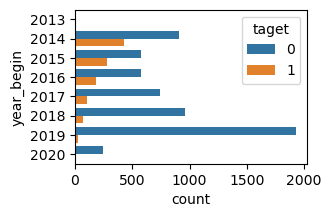

month_begin количество уникальных значений 12


month_begin
2     802
9     623
1     621
11    621
12    604
10    601
3     590
8     532
6     522
7     518
4     511
5     494
Name: count, dtype: int64

month_begin


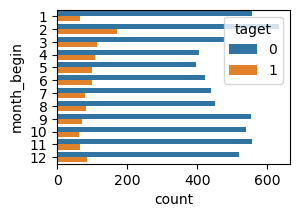

month_paid количество уникальных значений 3186
contract_use количество уникальных значений 251
Male количество уникальных значений 2


Male
1    3552
0    3487
Name: count, dtype: int64

Male


<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

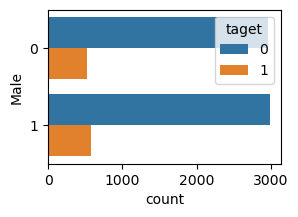

SeniorCitizen количество уникальных значений 2


SeniorCitizen
0    5897
1    1142
Name: count, dtype: int64

SeniorCitizen


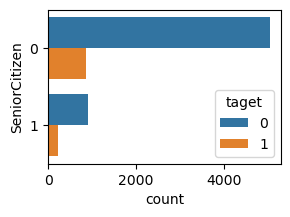

Partner количество уникальных значений 2


Partner
0    3639
1    3400
Name: count, dtype: int64

Partner


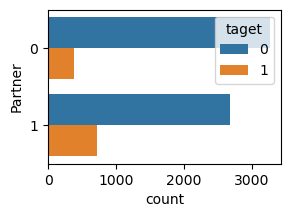

Dependents количество уникальных значений 2


Dependents
0    4930
1    2109
Name: count, dtype: int64

Dependents


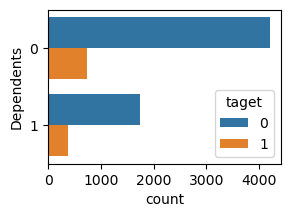

ServiceDSL количество уникальных значений 3


ServiceDSL
0.0000    3095
1.0000    2421
0.4389    1523
Name: count, dtype: int64

ServiceDSL


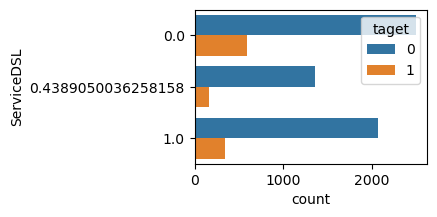

OnlineSecurity количество уникальных значений 3


OnlineSecurity
0.0000    3498
1.0000    2018
0.3658    1523
Name: count, dtype: int64

OnlineSecurity


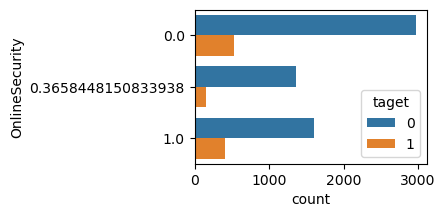

OnlineBackup количество уникальных значений 3


OnlineBackup
0.0000    3088
1.0000    2428
0.4402    1523
Name: count, dtype: int64

OnlineBackup


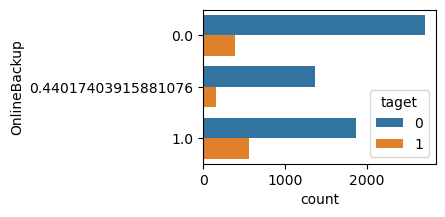

DeviceProtection количество уникальных значений 3


DeviceProtection
0.0000    3095
1.0000    2421
0.4389    1523
Name: count, dtype: int64

DeviceProtection


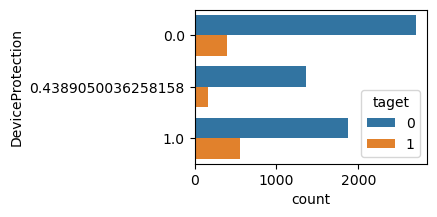

TechSupport количество уникальных значений 3


TechSupport
0.0000    3473
1.0000    2043
0.3704    1523
Name: count, dtype: int64

TechSupport


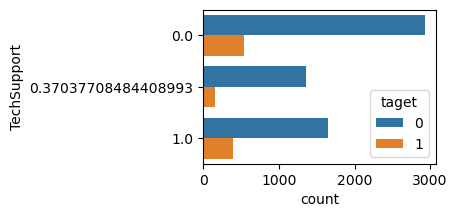

StreamingTV количество уникальных значений 3


StreamingTV
0.0000    2810
1.0000    2706
0.4906    1523
Name: count, dtype: int64

StreamingTV


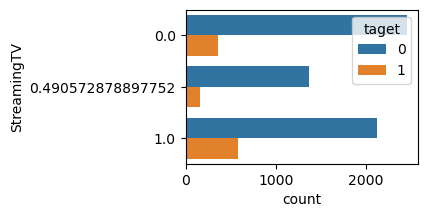

StreamingMovies количество уникальных значений 3


StreamingMovies
0.0000    2785
1.0000    2731
0.4951    1523
Name: count, dtype: int64

StreamingMovies


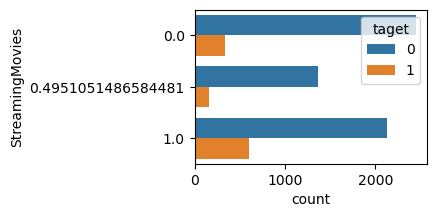

MultipleLines количество уникальных значений 3


MultipleLines
0.0000    3388
1.0000    2969
0.4670     682
Name: count, dtype: int64

MultipleLines


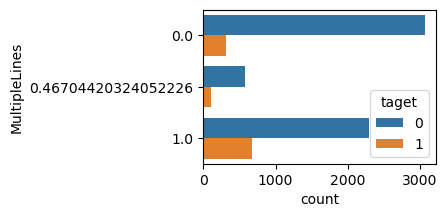

()

In [25]:
col_feature_tag(df_all,'taget')

## анализ количественных данных

'MonthlyCharges'

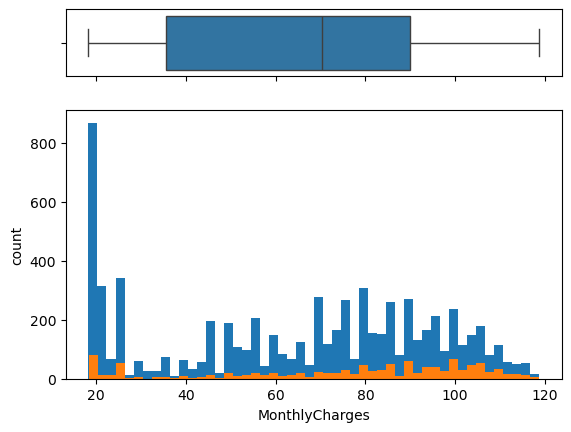

'экстемально низкие значения'

'MonthlyCharges'

np.float64(19.35)

'экстемально высокие значения'

'MonthlyCharges'

np.float64(111.55799999999999)

'TotalCharges'

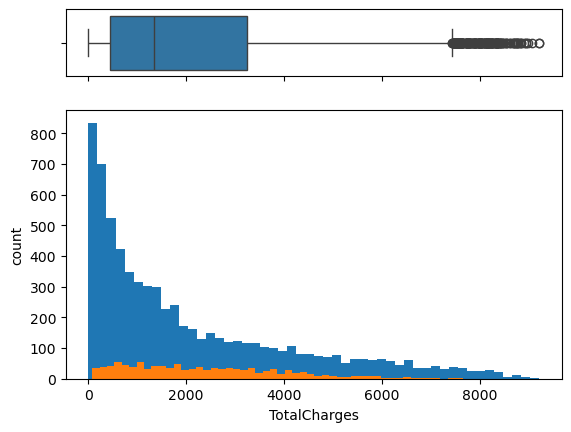

'экстемально низкие значения'

'TotalCharges'

np.float64(38.884)

'экстемально высокие значения'

'TotalCharges'

np.float64(7730.982399999999)

'month_paid'

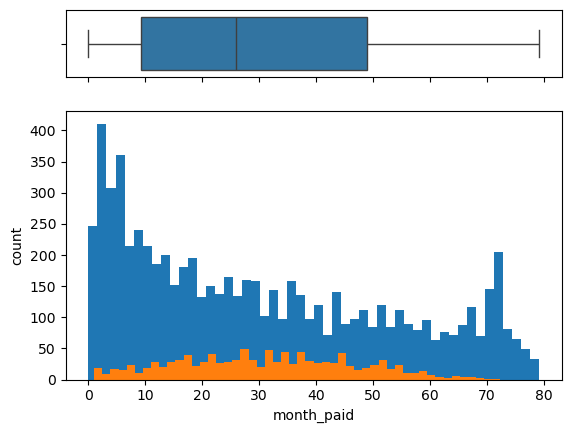

'экстемально низкие значения'

'month_paid'

np.float64(1.0101575000940097)

'экстемально высокие значения'

'month_paid'

np.float64(74.54994725069616)

'contract_use'

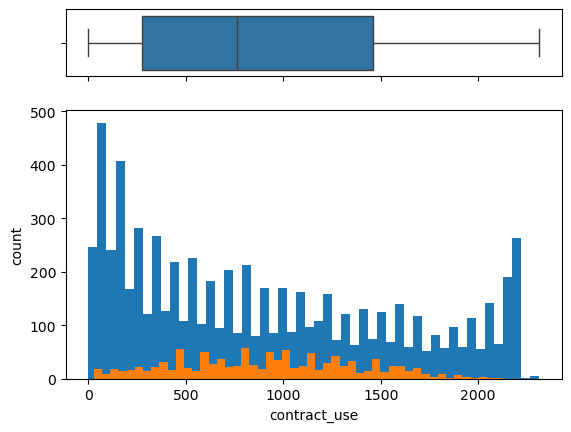

'экстемально низкие значения'

'contract_use'

np.float64(31.0)

'экстемально высокие значения'

'contract_use'

np.float64(2191.0)

In [26]:
num_feature = ["MonthlyCharges", "TotalCharges",'month_paid','contract_use']

for n in num_feature:
    if df_all[n].nunique() >= 50:
        display(n)
        fig, (ax_box, ax_hist) = plt.subplots(
            2,  # две строки в сетке подграфиков,
            sharex=True,  # единая шкала по оси x и
            gridspec_kw={"height_ratios": (0.20, 0.80)},
        )  # пропорция 20/80 по высоте
        sns.boxplot(x=df_all[n], ax=ax_box)
        plt.hist(df_all[n], bins=50)
        plt.hist(df_all[n][df_all['taget']==True], bins=50)
        # добавим подписи к каждому из графиков через метод .set()
        ax_box.set(xlabel="")  # пустые кавычки удаляют подпись (!)
        ax_hist.set(xlabel=n)
        ax_hist.set(ylabel="count")
        plt.show()
        mn=df_contract[n].quantile(0.02)
        mx=df_contract[n].quantile(0.98) #df[n].max
        display('экстемально низкие значения',n,mn)#df_contract[df_contract[n]<=mn])   
        display('экстемально высокие значения',n,mx)#,df_contract[df_contract[n]>=mx])
#display(df_contract[n_k_p].describe(include="all"))

## PHIK матрица

'PHIK матрица '

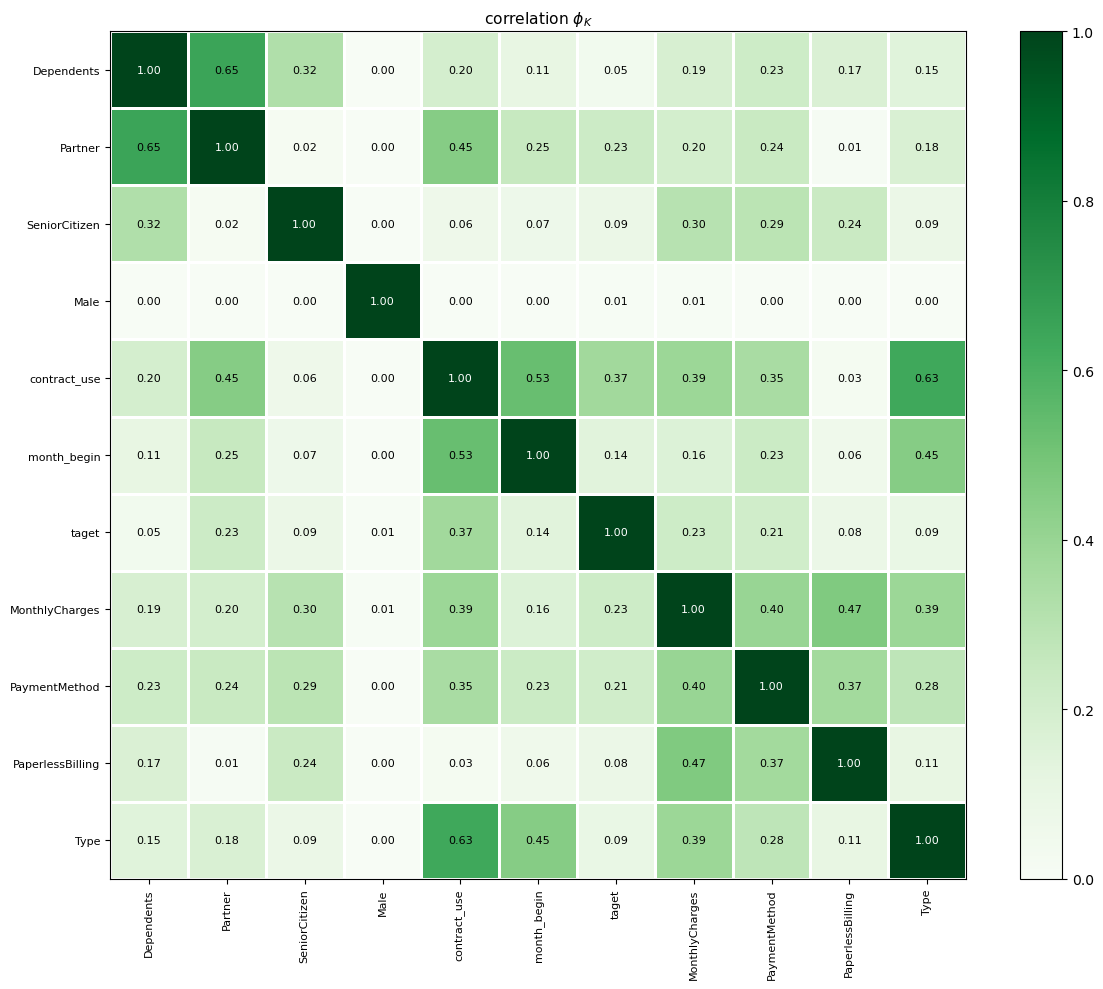

In [27]:
interval_cols = ["MonthlyCharges", 'contract_use']
df_phik = df_all.drop(["TotalCharges",
                       'BeginDate',
                       'EndDate',
                       'month_paid',
                       'month_end',
                       'year_end',
                       'year_begin',
                       'contract_day'], axis=1).copy()
df_phik = df_phik.drop(nul_col, axis=1).copy()
# 'PHIK матрица'
display ('PHIK матрица ')
phik_overview = phik_matrix(df_phik, interval_cols=interval_cols) # .drop('id', axis=1) ['customerID', 'BeginDate', 'EndDate'
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.8,
    figsize=(12,10))



## Выводы анализа данных

    - оплата в большестве случаев осуществляется помесячно
    - в начале года, наверное, проводятся акции по подключению новых клиентов - наблюдается приток договоров и актции длились в течении всего 2019 года - наибольший приток клиентов
    - отток клиентов наблюдается начиная с октября по январь
    - я считаю , что в 2019 часть клиентов перезаключило договора на новых условиях поэтому увеличение количества заключенных/расторгнутых договоров
    - я считаю, что если предположение выше верно , то из-за акции в 2019 данные имеют сильный "перекос" , поскольку данных по 2019 большинство (почти 28 % всех данных) и после "отчищения" данных от "дублирующих" клиентов модельь будет более точна, а так все статистика не особа точна
    - большмнство расходов не превышает 20 
    - среди тех , кто уже много потратил всего (более 6000) не наблюдается жалающих расторгнуть договор
    - по phik-матрице наблюдается явная зависимость признака ServiceDSL и MounthlyChenges. Поскольку влияние на target выше у МС - оставляем его 

# Разделение на test / train

In [28]:
df_all1 = df_phik#df_all.drop(['BeginDate', 'EndDate','month_end','year_end','contract_day','ServiceDSL'], axis=1).copy()
df_all1.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7039 non-null   string 
 1   PaperlessBilling  7039 non-null   object 
 2   PaymentMethod     7039 non-null   string 
 3   MonthlyCharges    7039 non-null   float64
 4   taget             7039 non-null   int32  
 5   month_begin       7039 non-null   int32  
 6   contract_use      7039 non-null   int64  
 7   Male              7039 non-null   object 
 8   SeniorCitizen     7039 non-null   object 
 9   Partner           7039 non-null   object 
 10  Dependents        7039 non-null   object 
dtypes: float64(1), int32(2), int64(1), object(5), string(2)
memory usage: 604.9+ KB


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_all1.drop(['taget'], axis=1),
    df_all1['taget'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_all1['taget'])
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 4601 to 5604
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5279 non-null   string 
 1   PaperlessBilling  5279 non-null   object 
 2   PaymentMethod     5279 non-null   string 
 3   MonthlyCharges    5279 non-null   float64
 4   month_begin       5279 non-null   int32  
 5   contract_use      5279 non-null   int64  
 6   Male              5279 non-null   object 
 7   SeniorCitizen     5279 non-null   object 
 8   Partner           5279 non-null   object 
 9   Dependents        5279 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(5), string(2)
memory usage: 433.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 6567 to 649
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1760 non-null   string 
 

In [30]:
X_train1, X_test1 = X_train, X_test

num_col =  interval_cols#num_feature
ohe_col = ['Type', 'PaymentMethod' ]
ord_col = [ 'month_begin']

# Преобразование признаков
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first',handle_unknown='error',sparse_output=False), ohe_col), #, dtype=np.bool_
    ('ord', OrdinalEncoder(), ord_col),
    ('std',StandardScaler(), num_col)
], remainder='passthrough',verbose_feature_names_out=True)


X_train_dp = data_preprocessor.fit_transform(X_train1)
X_test_dp = data_preprocessor.transform(X_test1)
#X_test1.info()

In [31]:
name_col_n = data_preprocessor.get_feature_names_out()
X_train_prepared = pd.DataFrame(X_train_dp,columns= name_col_n)
X_test_prepared = pd.DataFrame(X_test_dp,columns= name_col_n)
X_train_prepared.info()
X_train_prepared.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   ohe__Type_One year                          5279 non-null   object
 1   ohe__Type_Two year                          5279 non-null   object
 2   ohe__PaymentMethod_Credit card (automatic)  5279 non-null   object
 3   ohe__PaymentMethod_Electronic check         5279 non-null   object
 4   ohe__PaymentMethod_Mailed check             5279 non-null   object
 5   ord__month_begin                            5279 non-null   object
 6   std__MonthlyCharges                         5279 non-null   object
 7   std__contract_use                           5279 non-null   object
 8   remainder__PaperlessBilling                 5279 non-null   object
 9   remainder__Male                             5279 non-null   object
 10  remainder__SeniorCitizen

,ohe__Type_One year,ohe__Type_Two year,ohe__PaymentMethod_Credit card (automatic),ohe__PaymentMethod_Electronic check,ohe__PaymentMethod_Mailed check,ord__month_begin,std__MonthlyCharges,std__contract_use,remainder__PaperlessBilling,remainder__Male,remainder__SeniorCitizen,remainder__Partner,remainder__Dependents
0,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,1.2984,0.6850,1,1,0,0,0
1,0.0000,1.0000,0.0000,0.0000,1.0000,2.0000,0.3911,1.3098,1,0,0,1,1
2,0.0000,0.0000,0.0000,1.0000,0.0000,10.0000,1.2183,0.4158,1,0,1,1,0
3,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1.3884,0.7743,1,0,0,0,0
4,0.0000,0.0000,0.0000,1.0000,0.0000,11.0000,0.1877,-1.2303,0,0,0,0,0


In [32]:
df_tk = X_train_prepared.copy()
df_tk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   ohe__Type_One year                          5279 non-null   object
 1   ohe__Type_Two year                          5279 non-null   object
 2   ohe__PaymentMethod_Credit card (automatic)  5279 non-null   object
 3   ohe__PaymentMethod_Electronic check         5279 non-null   object
 4   ohe__PaymentMethod_Mailed check             5279 non-null   object
 5   ord__month_begin                            5279 non-null   object
 6   std__MonthlyCharges                         5279 non-null   object
 7   std__contract_use                           5279 non-null   object
 8   remainder__PaperlessBilling                 5279 non-null   object
 9   remainder__Male                             5279 non-null   object
 10  remainder__SeniorCitizen

# Кроссвалидация моделей

' матрица spearman'

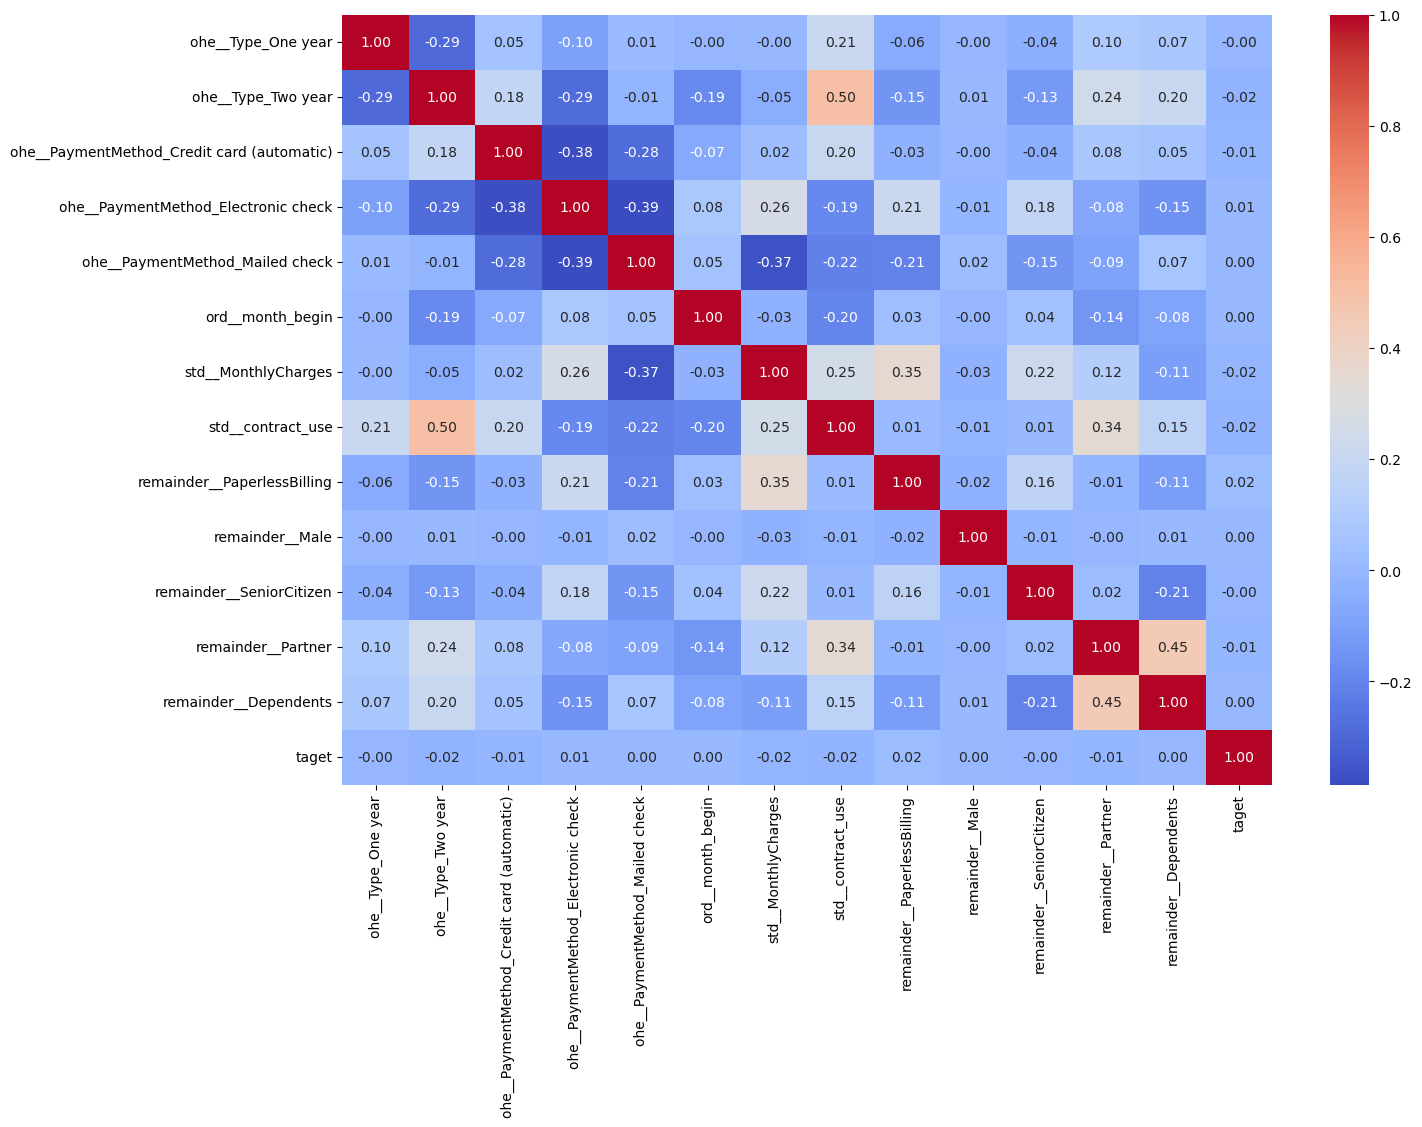

'spearman'

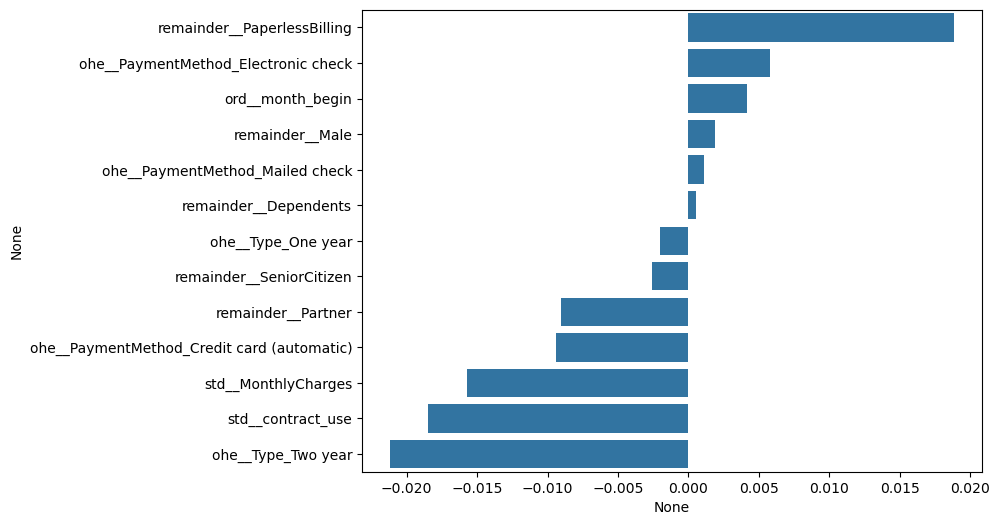

In [33]:
display (' матрица spearman')
df_tk['taget']=df_all['taget'].copy()

plt.figure(figsize = (15,10))
sns.heatmap(df_tk.corr(method='spearman'), fmt='.2f', annot=True,cmap='coolwarm')

plt.show()     
df_tk = df_tk.drop(['taget'], axis=1)
display ('spearman')
correlations = df_tk.corrwith(df_all['taget'],method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(8, 6)
plt.show() 

In [37]:
# фукция параметров кросвалидации моделей
def cv_model(clf,X_train,y_train):
        
   
    param_grid = {}
    if clf.__class__.__name__ == 'RandomForestClassifier' :
        param_grid = {'models__max_features': ('sqrt', 'log2', None, 1.),
                      'models__n_estimators' : (1, 100, 200),
                      'models__max_depth' :  (1, 100, 200)}
        
    elif clf.__class__.__name__ == 'RidgeClassifier' :
        param_grid = {'models__alpha': np.arange(0.01, 0.1, 0.05),
                     'models__tol': np.arange(0.001, 0.01, 0.05)}

    
    elif clf.__class__.__name__ == 'CatBoostClassifier' :    
        param_grid = {'models__depth': range(2, 4),
                      #'models__n_estimators' : ( 100, 200,500),
                      #'models__min_data_in_leaf':range(1,3)
                      }
        
    
    #display (X_train,X_test)
    pipe_final = Pipeline([('models',clf)])
    GridCV = GridSearchCV(
        pipe_final,
        param_grid=param_grid, 
        cv=3,
        scoring='roc_auc',
        error_score='raise',
        verbose=False,
        n_jobs=-1
    )
    GridCV.fit(X_train, y_train)
    clf_descr = clf.__class__.__name__
        
    print
    print(clf_descr)
    print(f"best parames :   {GridCV.best_params_}")
    print(f"best score :   {GridCV.best_score_}")
        
    #pred = GridCV.best_estimator_.predict(X_test)
    score = GridCV.best_score_ #f1_score(y_test, pred)
    
    return (clf_descr, score)

In [53]:
def cross_m (X_tr,y_train):
    
    results = []
    for clf in (
        (RandomForestClassifier(random_state=RANDOM_STATE)),
        (SGDClassifier(alpha=1e-4, n_iter_no_change=3, early_stopping=True)),
        (RidgeClassifier(max_iter=300,random_state=RANDOM_STATE)),
        
        (CatBoostClassifier(iterations=800, learning_rate=0.001, 
                            loss_function='CrossEntropy',eval_metric='AUC',
                            random_seed = RANDOM_STATE, #task_type = 'СPU',
                            early_stopping_rounds = 200,
                            allow_writing_files=False,
                            verbose= False))
    ):
        print("=" * 80)
        
        #model_name,m_score = (cv_model(clf,X_tr,X_ts))
        results.append(cv_model(clf,X_tr,y_train) )
    return results

In [54]:
results_all = cross_m(X_train_prepared,y_train)
results_all

RandomForestClassifier
best parames :   {'models__max_depth': 100, 'models__max_features': None, 'models__n_estimators': 200}
best score :   0.9087114493724545
SGDClassifier
best parames :   {}
best score :   0.6482282018101866
RidgeClassifier
best parames :   {'models__alpha': np.float64(0.060000000000000005), 'models__tol': np.float64(0.001)}
best score :   0.7267461557895594
CatBoostClassifier
best parames :   {'models__depth': 3}
best score :   0.8118835555313542


[('RandomForestClassifier', np.float64(0.9087114493724545)),
 ('SGDClassifier', np.float64(0.6482282018101866)),
 ('RidgeClassifier', np.float64(0.7267461557895594)),
 ('CatBoostClassifier', np.float64(0.8118835555313542))]

In [55]:
res_df=pd.DataFrame(results_all,columns=['model_n','ROC_AUC'])
res_df

,model_n,ROC_AUC
0,RandomForestClassifier,0.9087
1,SGDClassifier,0.6482
2,RidgeClassifier,0.7267
3,CatBoostClassifier,0.8119


,model_n,ROC_AUC
1,SGDClassifier,0.6482
2,RidgeClassifier,0.7267
3,CatBoostClassifier,0.8119
0,RandomForestClassifier,0.9087


<Figure size 1000x800 with 0 Axes>

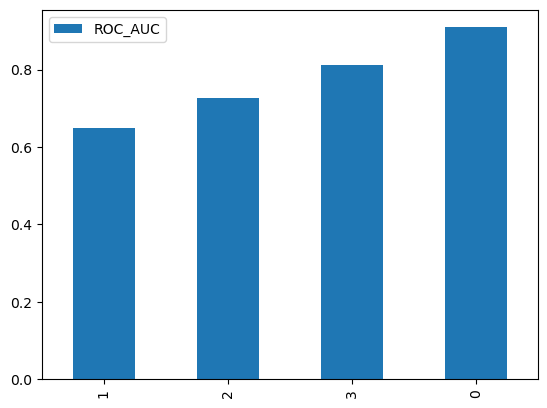

In [56]:
res_df['ROC_AUC']=res_df['ROC_AUC']
res_df = res_df.sort_values(['ROC_AUC'])
display(res_df)
plt.figure(figsize=(10,8))
res_df.plot.bar()# plt.hist(res_df1,density=True)
plt.show()    

# Моделирование нейронной сети

In [57]:
X_train_prepared1 = X_train_prepared.astype('float').copy()
X_test_prepared1 = X_test_prepared.astype('float').copy()


In [58]:
X_train_nn = torch.from_numpy(X_train_prepared1.values)
X_test_nn = torch.from_numpy(X_test_prepared1.values)
y_train_nn = torch.tensor(y_train.values)
y_test_nn = torch.tensor(y_test.values)

In [59]:
# Создание модели
import tensorflow as tf
input_dim = X_train_nn.shape[1]

def auroc(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float64)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    
model = Sequential()
model.add(Dense(32, input_dim=input_dim, activation='relu'))
#model.add(Dense(16,  activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])#,auroc])

# Обучение модели
model.fit(X_train_nn, y_train_nn, epochs=45, batch_size=32)


Epoch 1/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5868 - auc_1: 0.4642 - loss: 0.7155    
Epoch 2/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8501 - auc_1: 0.6247 - loss: 0.4108 
Epoch 3/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530 - auc_1: 0.7285 - loss: 0.3774 
Epoch 4/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - auc_1: 0.7877 - loss: 0.3713 
Epoch 5/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - auc_1: 0.8042 - loss: 0.3457 
Epoch 6/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8655 - auc_1: 0.8174 - loss: 0.3282 
Epoch 7/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - auc_1: 0.8118 - loss: 0.3468 
Epoch 8/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8721 - auc_1: 0.8274 - loss: 0.3223 
Epoch 9/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8622 - auc_1: 0.8256 - loss: 0.3355 
Epoch 10/45
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.860

In [60]:
train_loss, train_acc,  train_roc_auc = model.evaluate(X_train_nn, y_train_nn)
display(train_loss, train_acc,  train_roc_auc)
# Делаем предсказания
predictions = model.predict(X_train_nn)

# Дополнительно вычисляем ROC AUC на предсказаниях
roc_auc = roc_auc_score(y_train, predictions)
print(f"ROC AUC (train): {roc_auc:.4f}")
res_df.loc[len(res_df)] =['NeiroNet',roc_auc]
res_df = res_df.sort_values(['ROC_AUC'],ascending=False)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8690 - auc_1: 0.8613 - loss: 0.3080   


0.310698926448822

0.8706194162368774

0.8509016036987305

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
ROC AUC (train): 0.8510


<Figure size 1600x1400 with 0 Axes>

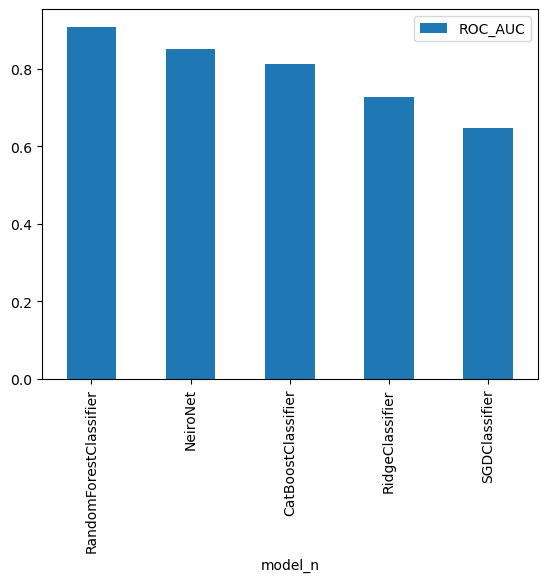

In [61]:
#res_df = res_df['ROC_AUC']-0.9
res_df = res_df.set_index(['model_n'])

plt.figure(figsize=(16,14))
res_df.plot.bar()# plt.hist(res_df1,density=True)
plt.show() 

# Анализ лучшей модели 

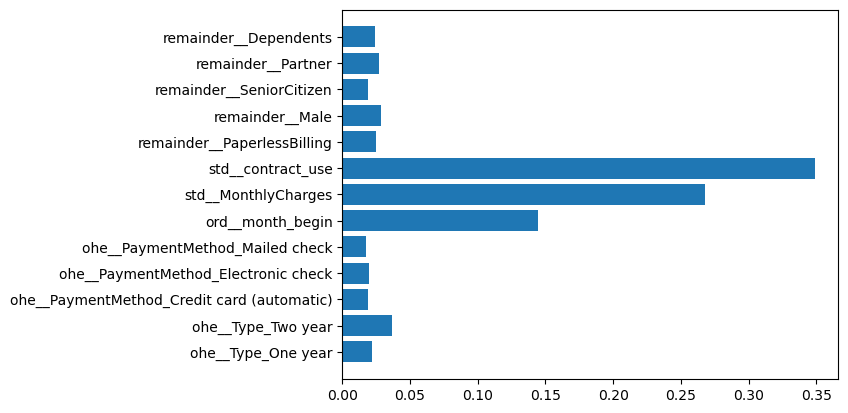

In [62]:
model_rf = RandomForestClassifier(max_depth=100,n_estimators=200)
model_rf.fit(X_train_prepared,y_train)


features = X_train_prepared.columns
importance_values = model_rf.feature_importances_#coef_[0]
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()

In [66]:
pred_test = model_rf.predict(X_test_prepared)

roc_au = roc_auc_score(pred_test,y_test)
display ('Roc  RandomForest test ',roc_au)
display(confusion_matrix(y_test,pred_test,
                         labels = [0, 1]))
rfc_tn, rfc_fp, rfc_fn, rfc_tp = confusion_matrix(y_test,pred_test,
                         labels = [0, 1]).ravel()
sum_r=rfc_tn+ rfc_fp+ rfc_fn+ rfc_tp
display('общая точность предсказания ACCURANCY',(rfc_tn+ rfc_fp)/sum_r)
display('точность предсказания PRECISION',(rfc_tp/(rfc_tp+rfc_fp)))
display('полнота предсказания RECALL',(rfc_tp/(rfc_tp+rfc_fn)))
print(classification_report(y_test,pred_test))



'Roc  RandomForest test '

np.float64(0.8017892962004709)

array([[1463,   22],
       [ 215,   60]])

'общая точность предсказания ACCURANCY'

np.float64(0.84375)

'точность предсказания PRECISION'

np.float64(0.7317073170731707)

'полнота предсказания RECALL'

np.float64(0.21818181818181817)

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1485
           1       0.73      0.22      0.34       275

    accuracy                           0.87      1760
   macro avg       0.80      0.60      0.63      1760
weighted avg       0.85      0.87      0.83      1760



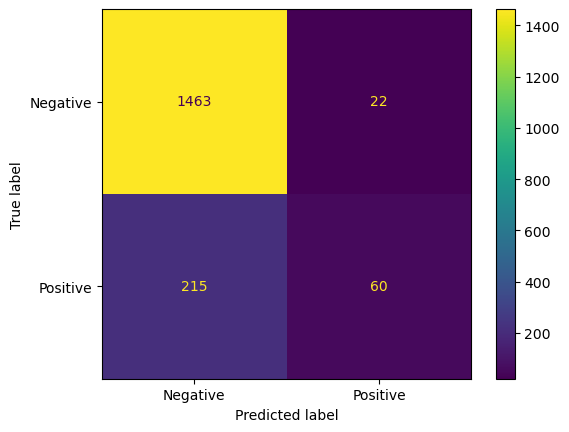

In [67]:
# Матрица ошибок
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

# Выводы по модели

    - значение метрики на тестовой выборке составило -0.9738
    - значение ACCURANCY на тестовой выборке составило - 0.84375
    - точность предсказания PRECISION - 1.0
    - полнота предсказания RECALL - 0.5164
    - оссновные факторы , влияющие на прогноз по модели RandomForest:
            - contract_use -(количество месяцев , которые оплачивал клиент)
            - year_begin - (год начала котракта)
            - month_paid (сумма , которую тратит клиент в месяц)

## Графики "важных" признаков

'month_paid'

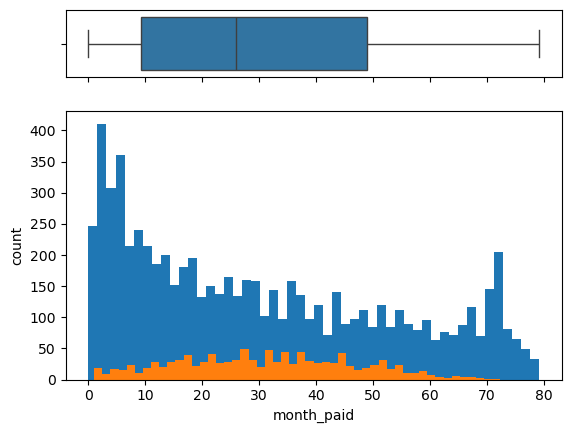

'contract_use'

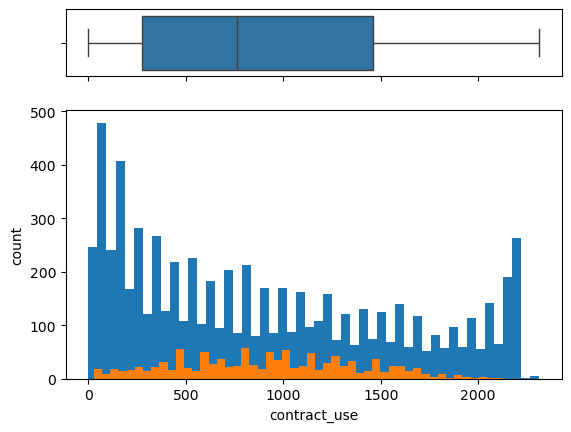

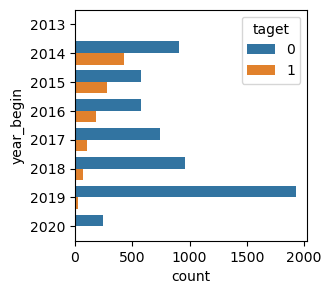

In [64]:
num_feature = ['month_paid','contract_use']

for n in num_feature:
    if df_all[n].nunique() >= 50:
        display(n)
        fig, (ax_box, ax_hist) = plt.subplots(
            2,  # две строки в сетке подграфиков,
            sharex=True,  # единая шкала по оси x и
            gridspec_kw={"height_ratios": (0.20, 0.80)},
        )  # пропорция 20/80 по высоте
        sns.boxplot(x=df_all[n], ax=ax_box)
        plt.hist(df_all[n], bins=50)
        plt.hist(df_all[n][df_all['taget']==True], bins=50)
        # добавим подписи к каждому из графиков через метод .set()
        ax_box.set(xlabel="")  # пустые кавычки удаляют подпись (!)
        ax_hist.set(xlabel=n)
        ax_hist.set(ylabel="count")
        plt.show()
        
plt.figure(figsize=(3, 3))
sns.countplot(y='year_begin', data=df_all,hue ='taget')
plt.show()


# Общие выводы

    - данные необходимо уточнить: в 2019 что-то произошло, что количество новых договоров резко возрасло. Это необычно
    - Нейронную сеть можно было обучить до больших значений метрик, но интерпретировать причины оттока клиентов было бы сложнее
    - возможно , если рассмотривать данные с 2019 года модель будет более дольше работопригодной

    Бизнес-рекомендации:
    - клиенты , которые пользуются услугами больше 2 лет - менее склонны расторгать договор
    - клиенты, которые используют дополниетльные услуги - более стабильны
    - StreamingMovies - менее полезная услуга, с точки зрения "удержания" клиентов. Наиболее "полезны" OnlineBackup,TechSupport,OnlineSecurity. Значит нужно либо улучшить StreamingMovies, либо не развивать ее совсем , поддерживая и развивая более полезные дополнительные услуги